In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Example I: Deblurring

This example is provided to demonstrate ill-posed deblurring in the framework of inverse problems. We set out to show the following:

- How noise affects reconstruction for a convolution operator in the frequency domain via Fourier and Cosine transforms.
- How deconvolution in the FFT domain can be used to solve deblurring problems.
- How least squares approximations can be applied to solve deblurring problems.
- How truncated SVD (TSVD) can be applied for deblurring.
- How Tikhonov regularization can be applied for deblurring.
- How gradient descent methods performs w.r.t. deblurring.

We begin by importing our tools and data.

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
# Get Data and transforms
classes = 100
tf = [transforms.Grayscale()]
train = datasets.get_cifar(classes, transform=tf)
test = datasets.get_cifar(classes, transform=tf, train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 48
nu = 1e-3
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}


Next, we generate a discrete 3x3 moving average blur filter using convolution.

In [4]:
# Generate Blur
blur = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur.weight.data[...] = 1/9
blur.train(False);

# Generate GPU version
blur_gpu = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur_gpu.weight.data[...] = 1/9
blur_gpu.train(False);
blur_gpu.to(device);

We generate the blurred image as well as a version with Gaussian noise from $\mathcal N(0, .01^2)$ and plot the three images.

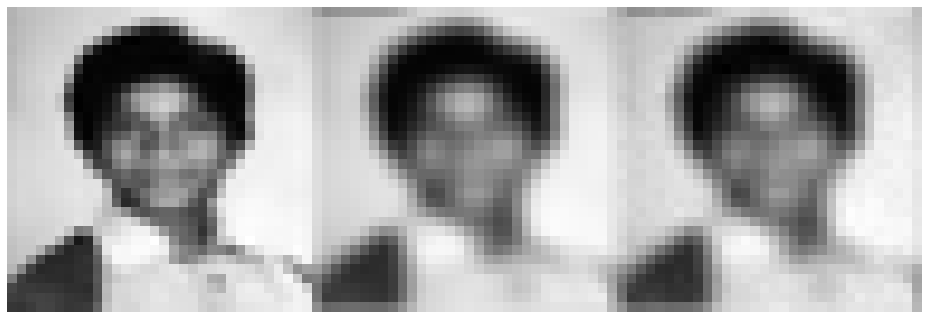

In [5]:
img = train[3][0][None, ...]
img_blur = blur(img).detach()
noise = torch.randn(*train.data.shape[:-1]) * .01
img_blur_noise = img_blur + noise[3]
imshow(
    torch.cat([
        img[0,0],
        img_blur[0,0],
        img_blur_noise[0,0],
    ], dim=1).clip(0,1).numpy(),
    filename='example_i_images'
)

The original is on the left, the blurred image is in the middle and the noisy 

Next we visualize the images in the Fourier domain.

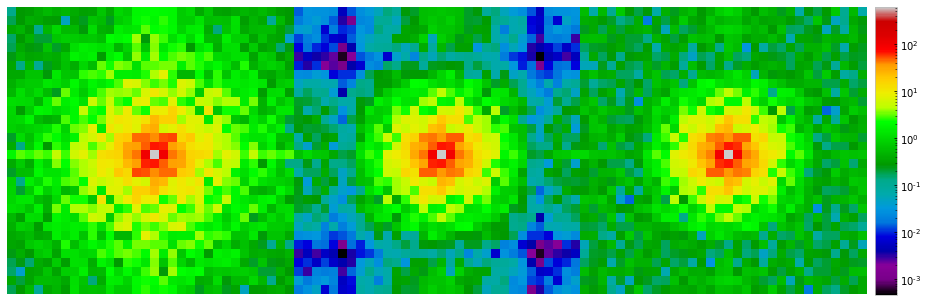

In [6]:
fig, ax = plt.subplots()
im = ax.matshow(
    torch.cat([
        fft.fftshift(fft.fft2(img)[0,0]),
        fft.fftshift(fft.fft2(img_blur)[0,0]),
        fft.fftshift(fft.fft2(img_blur_noise)[0,0])
    ], dim=1).abs().numpy(), 
    norm=LogNorm()
);
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01, orientation="vertical", aspect=13.5);
plt.axis('off')
plt.grid(False)
plt.savefig("../figures/misc/example_i_fft.pdf");

Note that the corners of the blurred image displays certain symmetric patterns in the frequency domain indicative of the applied blur kernel, and that this information is lost in the frequency domain of the noisy image. Next, we visualize the images using Discrete Cosine Transform.

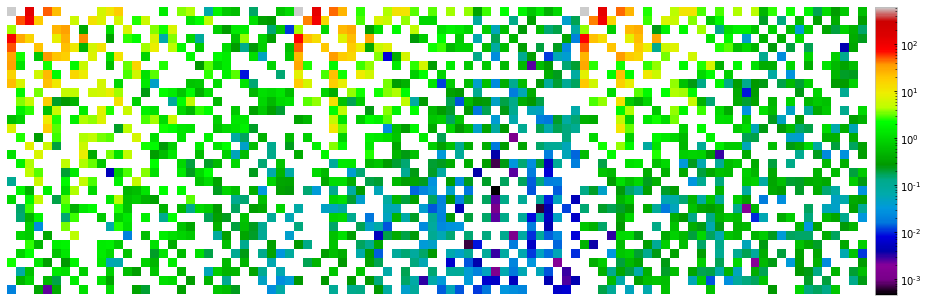

In [7]:
fig, ax = plt.subplots()
ax.matshow(
    torch.cat([
        utils.dct2(img)[0,0],
        utils.dct2(img_blur)[0,0],
        utils.dct2(img_blur_noise)[0,0]
    ], dim=1).numpy(), 
    norm=LogNorm()
);
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01, orientation="vertical", aspect=13.5);
plt.axis('off')
plt.grid(False);
plt.savefig("../figures/misc/example_i_dct.pdf");

The DCT does not exhibit as clear symmetrical patterns as the DFT. However, the frequency is clearly altered in the blurred image, and these changes are again less prevalent in the noisy version.

A deconvolution problem can be solved in the Fourier domain, where for fome convolution kernel $h(t)$ acting on a signal $x(t)$ as follows

$$
\begin{align}
    x(t) * h(t) &= y(t) \\
\end{align}
$$

we, by application of the Convolution Theorem, can write

$$
\begin{align}
    \mathcal F(x(t) * h(t)) &= \tilde x(t) \circ \tilde h(t) \\
    &= \tilde y(t)
\end{align}
$$

such that one can apply

$$
\begin{align}
    \tilde y(t) \circ [\tilde x(t)]^{-1} = \tilde h(t).
\end{align}
$$

We apply this method to retrieve the convolution kernel in the Fourier domain for our sample image.

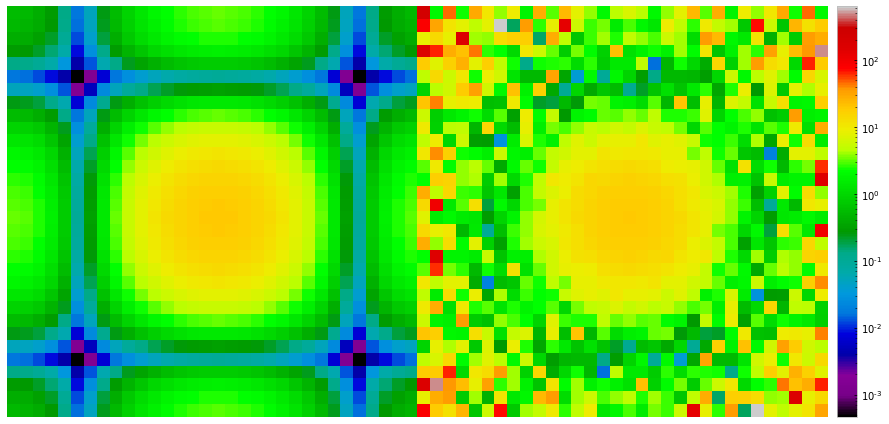

In [8]:
fig, ax = plt.subplots()
ax.matshow(
    torch.cat([
        fft.fftshift((Hf := fft.fft2(img_blur)[0,0] / fft.fft2(img)[0,0])),
        fft.fftshift((Hfn := fft.fft2(img_blur_noise)[0,0] / fft.fft2(img)[0,0]))
    ], dim=1).abs(),
    norm=LogNorm()
);
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01, orientation="vertical", aspect=20);
plt.axis('off')
plt.grid(False);
plt.savefig("../figures/misc/example_i_convfft.pdf");

We note that the kernel for the noisy image on the left is visibly corrupted compared to the noiseless version on the right. The convolution theorem can also be derived to apply for the DCT. The extracted kernel shows similar corruption, however the symmetric patterns are the true filter is much less prominent.

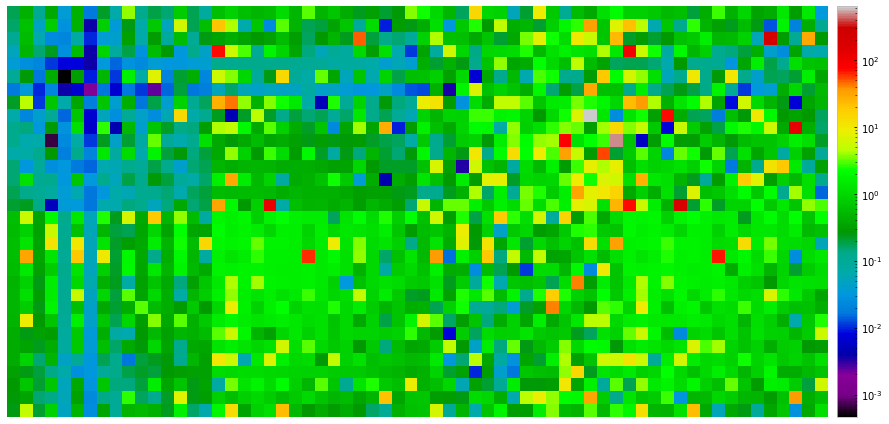

In [9]:
fig, ax = plt.subplots()
ax.matshow(
    torch.cat([
        fft.fftshift((Hd := utils.dct2(img_blur)[0,0] / utils.dct2(img)[0,0])),
        fft.fftshift((Hdn := utils.dct2(img_blur_noise)[0,0] / utils.dct2(img)[0,0]))
    ], dim=1).abs(),
    norm=LogNorm()
);
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01, orientation="vertical", aspect=20);
plt.axis('off')
plt.grid(False);
plt.savefig("../figures/misc/example_i_convdct.pdf");

Applying the estimated filters, we can reconstruct the original images.

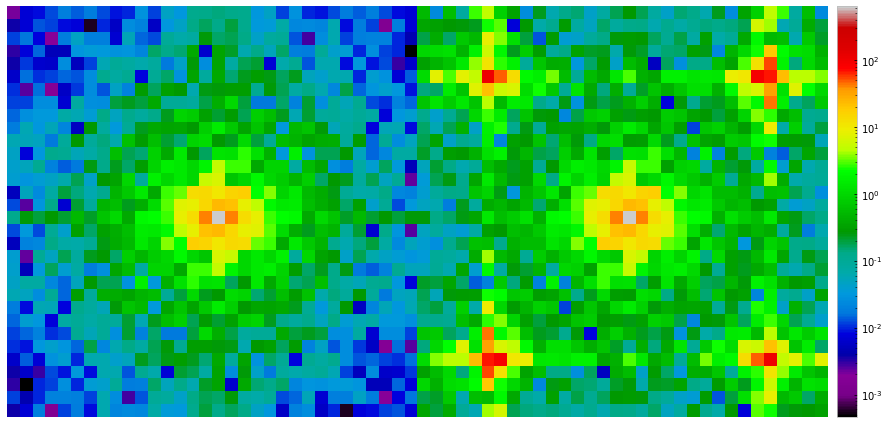

In [10]:
fig, ax = plt.subplots()
ax.matshow(
    torch.cat([
        fft.fftshift(fft.fft2(img_blur)[0,0] / Hf),
        fft.fftshift(fft.fft2(img_blur_noise)[0,0] / Hf) 
    ], dim=1).abs(),
    norm=LogNorm()
)
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01, orientation="vertical", aspect=20);
plt.axis('off')
plt.grid(False);
plt.savefig('../figures/misc/example_i_deconv_fft_spectra.pdf')

PSNR:  1.41950E+02  5.64060E+00
SSIM:  1.00000E+00  2.66651E-01


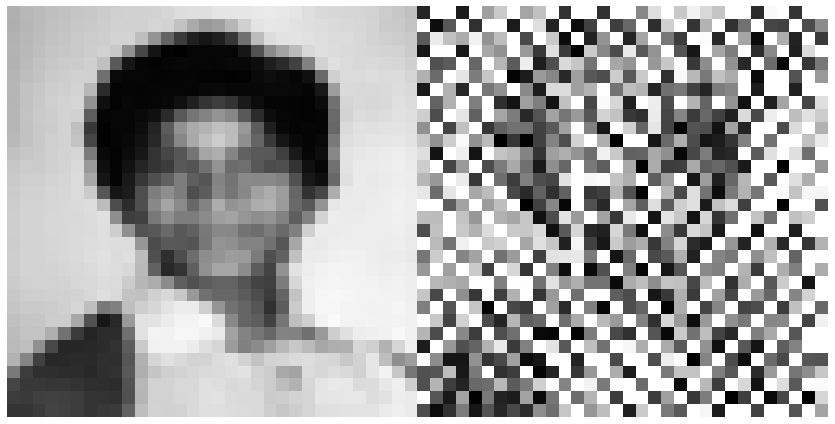

In [11]:
imshow(
    torch.cat([
        (img_blur_fft := fft.ifft2(fft.fft2(img_blur)[0,0] / Hf)),
        (img_noise_fft := (fft.ifft2(fft.fft2(img_blur_noise)[0,0] / Hf)))
    ], dim=1).abs().clip(0,1),
    filename='example_i_deconv_fft'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_fft.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_fft.abs(), img[0,0]).item(),
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_fft.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_fft.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

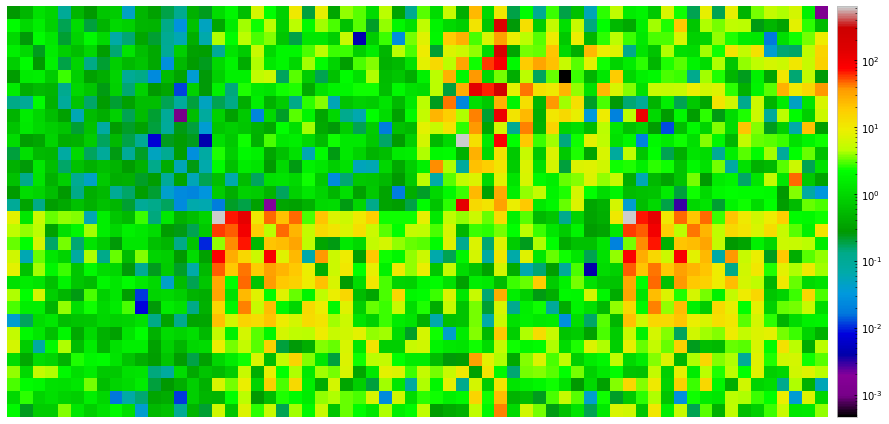

In [12]:
fig, ax = plt.subplots()
ax.matshow(
    torch.cat([
        fft.fftshift(utils.dct2(img_blur)[0,0] / Hd),
        fft.fftshift(utils.dct2(img_blur_noise)[0,0] / Hd) 
    ], dim=1).abs(),
    norm=LogNorm()
)
fig.colorbar(im, ax=ax, fraction=0.024, pad=0.01, orientation="vertical", aspect=20);
plt.axis('off')
plt.grid(False);
plt.savefig('../figures/misc/example_i_deconv_dct_spectra.pdf')

PSNR:  1.41085E+02  3.46035E+00
SSIM:  1.00000E+00  1.79491E-01


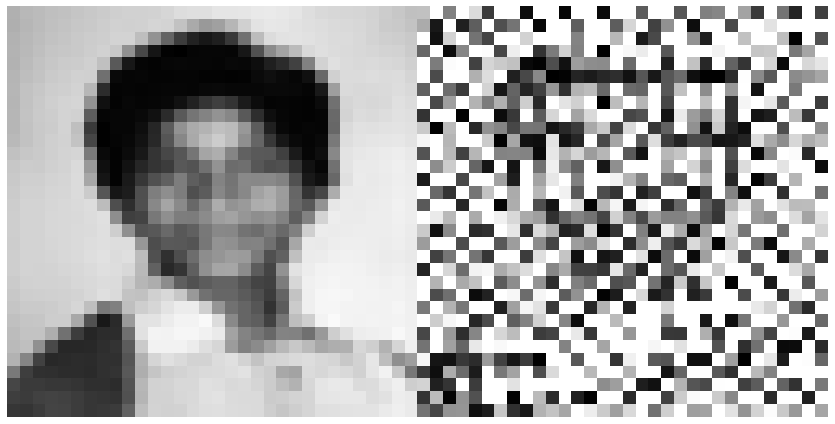

In [13]:
imshow(
    torch.cat([
        (img_blur_dct := utils.idct2(utils.dct2(img_blur)[0,0] / Hd)),
        (img_noise_dct := utils.idct2(utils.dct2(img_blur_noise)[0,0] / Hd)),
    ], dim=1).abs().clip(0,1),
    filename='example_i_deconv_dct'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_dct.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_dct.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_dct.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_dct.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

Both the DFT and the DCT provide excellent reconstructions for the blurred images, however for the noisy image both the DFT and DCT reconstructions are barely recognizable compared to the original image.

In [14]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])
test_indices = np.arange(len(test))

# Convert sample indices to tensors
xs = torch.stack([train[i][0] for i in sample_indices_small]).to(device)
xt = torch.stack([test[i][0] for i in test_indices]).to(device)
ys = blur_gpu(xs)
yt = blur_gpu(xt)

# Generate noise for samples
noise_samples = noise[sample_indices_small].flatten(-1).to(device)

#### Naive solution 1

One method of finding a closed form solution for a single image $X$ is by assuming $W = W^*$. Then

$$
\begin{align}
    W X W^T &= Y \\
    X^{1/2} W X W X^{1/2} &= X^{1/2} Y X^{1/2} \\
    (X^{1/2} W X^{1/2}) (X^{1/2} W^* X^{1/2}) &= X^{1/2} Y X^{1/2} \\
    X^{1/2} W X^{1/2} &= (X^{1/2} Y X^{1/2})^{1/2} \\
    \hat W &= X^{-1/2}(X^{1/2} Y X^{1/2})^{1/2}X^{-1/2},
\end{align}
$$

which can also be applied to find $\hat W^{-1}$. This applied solution is however very unstable, and does not necessarily translate to other images as the assumption of sequilinear symmetry is not necessarily true for the underlying operator $W$. 

PSNR:  4.11900E+01 -9.19587E+00
SSIM:  9.98412E-01  4.12448E-02


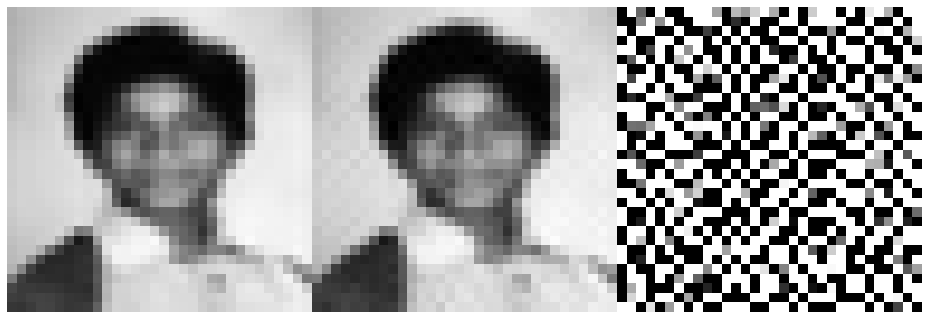

In [15]:
Xim = xs[1,0]
Yim = ys[1,0].detach()
Yim_noise = (ys + noise_samples)[1,0].detach()

U = utils.matrix_fracpow(Yim, 1/2)
Uinv = utils.matrix_fracpow(Yim, -1/2)
C = utils.matrix_fracpow(U @ (Xim + 0.j) @ U, 1/2)

W = (Uinv @ C @ Uinv).real

imshow(
    torch.cat([
        img[0,0],
        (img_blur_sep := (W @ (Yim) @ W).cpu()), 
        (img_noise_sep := (W @ (Yim_noise) @ W).cpu())
    ], dim=1).clip(0,1),
    filename='example_i_deconv_naive_closed_form'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_sep.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_sep.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_sep.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_sep.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

#### Naive Solution 2

A more practical solution can be found by utilizing that $W X W^T = Y$ can be vectorized using the Kronecker product. In general we have

$$
\begin{align}
    W X W^T &= Y \Leftrightarrow (W \otimes W) \mathrm{vec}(X) = \mathrm{vec}(Y).
\end{align}
$$

Then letting $X' = (\mathrm{vec}(X_i))_{i \in \mathcal I}$ and $Y' = (\mathrm{vec}(Y_i))_{i \in \mathcal I}$, we can apply the Moore-Penrose pseudoinverse to compute

$$
\begin{align}
    X'W &= Y'\\
    W &= (X')^\dagger Y'
\end{align}
$$

and similarily $W^{-1} = (Y')^\dagger X'$. This is the ordinary least squares method.

In [16]:
Xprime = torch.tensor(train.data / 255.).float().mean(-1)[:,None,...] # Greyscale
with torch.no_grad():
    Yprime = blur(Xprime)

Xprime = Xprime.flatten(-3, -1)
Yprime_noise = (Yprime + noise[:,None,...]).flatten(-3, -1)
Yprime = Yprime.flatten(-3, -1)

In [17]:
W = torch.pinverse(Yprime) @ Xprime

In [18]:
torch.linalg.svdvals(W)

tensor([751.3116, 728.9828, 707.3385,  ...,   1.0130,   1.0130,   1.0000])

PSNR:  4.05266E+01  5.63932E+00
SSIM:  9.98877E-01  2.65561E-01


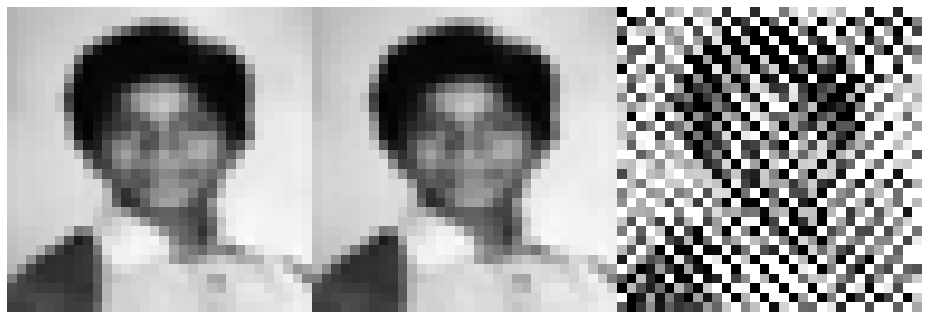

In [19]:
imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_ols := (W @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_ols := (W @ Yprime_noise[3]).unflatten(-1, (32, 32)))
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_ols.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_ols.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_ols.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_ols.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

#### Truncated SVD

Instead of computing the ordinary least squares solution, we can instead limit the number of singular values in the reconstruction.

In [20]:
U, S, V = torch.linalg.svd(Yprime, full_matrices=False)

PSNR:  3.48759E+01  2.14616E+01
SSIM:  9.94603E-01  8.87183E-01


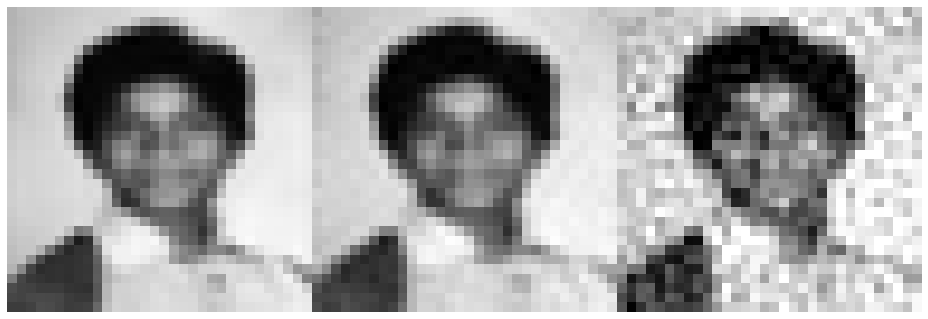

In [21]:
trunc = torch.ones(len(S))
k = 750
trunc[k:] = 0
Yprimeinv = V.T @ torch.diag(trunc/S) @ U.T
Wtrunc = Yprimeinv @ Xprime

imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_tsvd750 := (Wtrunc @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_tsvd750 := (Wtrunc @ Yprime_noise[3]).unflatten(-1, (32, 32)))
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols_tsvd_750'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_tsvd750.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_tsvd750.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_tsvd750.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_tsvd750.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

PSNR:  3.00352E+01  2.69746E+01
SSIM:  9.82618E-01  9.62377E-01


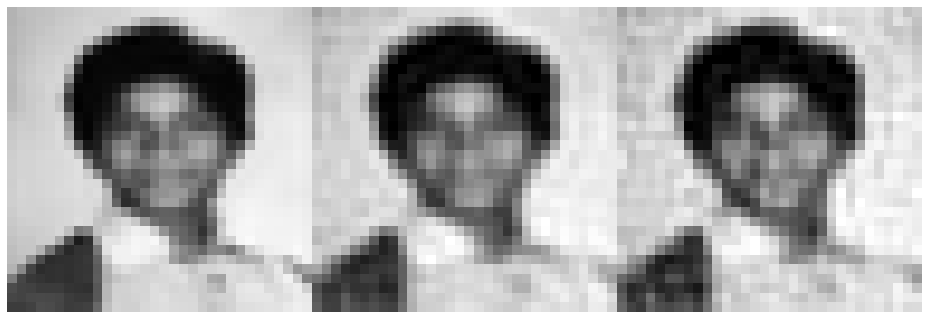

In [22]:
trunc = torch.ones(len(S))
k = 500
trunc[k:] = 0
Yprimeinv = V.T @ torch.diag(trunc/S) @ U.T
Wtrunc = Yprimeinv @ Xprime

imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_tsvd500 := (Wtrunc @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_tsvd500 := (Wtrunc @ Yprime_noise[3]).unflatten(-1, (32, 32)))
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols_tsvd_500'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_tsvd500.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_tsvd500.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_tsvd500.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_tsvd500.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

PSNR:  2.62732E+01  2.60965E+01
SSIM:  9.62161E-01  9.59070E-01


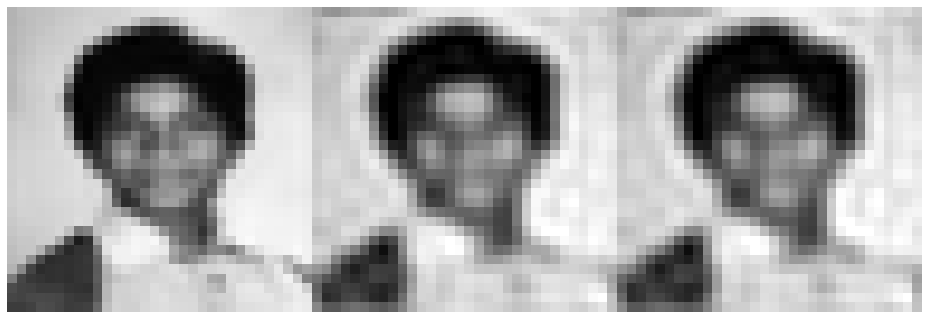

In [23]:
trunc = torch.ones(len(S))
k = 250
trunc[k:] = 0
Yprimeinv = V.T @ torch.diag(trunc/S) @ U.T
Wtrunc = Yprimeinv @ Xprime

imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_tsvd250 := (Wtrunc @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_tsvd250 := (Wtrunc @ Yprime_noise[3]).unflatten(-1, (32, 32)))  
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols_tsvd_250'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_tsvd250.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_tsvd250.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_tsvd250.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_tsvd250.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

#### Tikhonov Regularization / Ridge Regression

Comparing with the TSVD and OLS we can apply Tikhonov regularization, which applies a penalty term to the L2 norm of the weight matrix $W$.

PSNR:  3.42689E+01  2.49220E+01
SSIM:  9.93880E-01  9.40192E-01


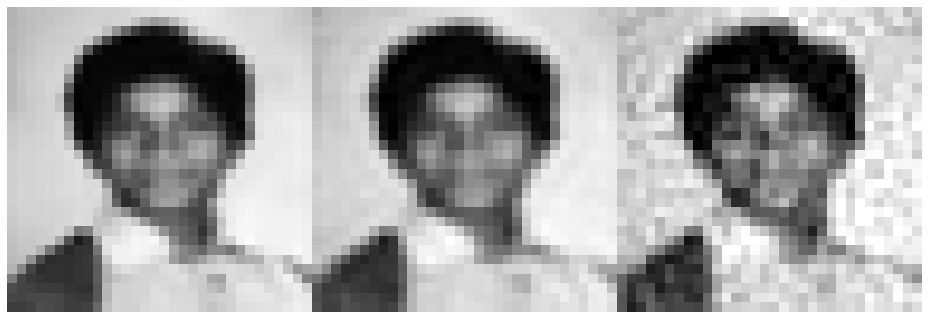

In [24]:
alpha = 0.5
SL2 = S / (S**2 + alpha**2)

Wreg = V.T @ torch.diag(SL2) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_lr05 := (Wreg @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_lr05 := (Wreg @ Yprime_noise[3]).unflatten(-1, (32, 32)))  
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols_l2_0_5'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_lr05.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_lr05.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_lr05.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_lr05.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

PSNR:  2.91704E+01  2.82917E+01
SSIM:  9.80874E-01  9.74280E-01


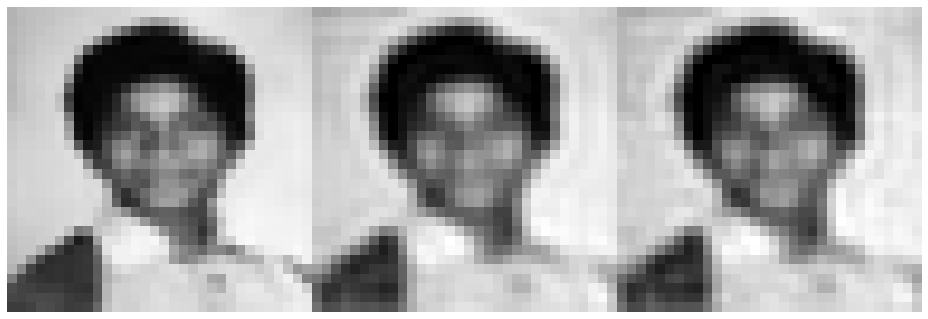

In [25]:
alpha = 2.5
SL2 = S / (S**2 + alpha**2)

Wreg = V.T @ torch.diag(SL2) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_lr10 := (Wreg @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_lr10 := (Wreg @ Yprime_noise[3]).unflatten(-1, (32, 32)))  
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols_l2_1_0'    
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_lr10.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_lr10.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_lr10.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_lr10.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

PSNR:  2.72758E+01  2.70817E+01
SSIM:  9.71463E-01  9.68893E-01


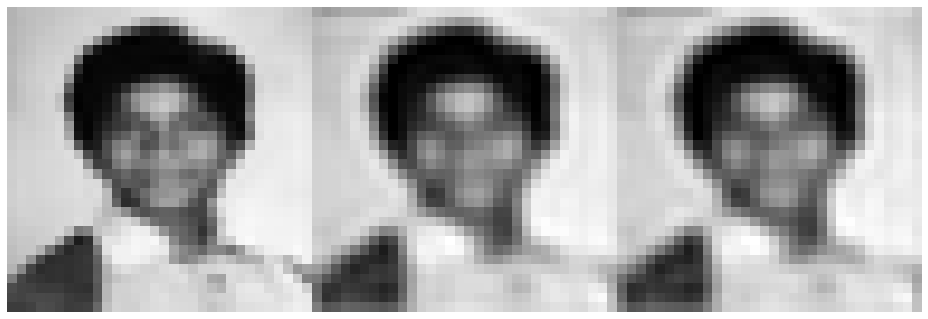

In [26]:
alpha = 5.0
SL2 = S / (S**2 + alpha**2)

Wreg = V.T @ torch.diag(SL2) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[3].unflatten(-1, (32, 32)),
        (img_blur_lr20 := (Wreg @ Yprime[3]).unflatten(-1, (32, 32))),
        (img_noise_lr20 := (Wreg @ Yprime_noise[3]).unflatten(-1, (32, 32))) 
    ], dim=1).clip(0,1),
    filename='example_i_deconv_ols_l2_2_0'    
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_blur_lr20.abs(), img[0,0]).item(),
        utils.metrics.psnr(img_noise_lr20.abs(), img[0,0]).item()
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_blur_lr20.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
        utils.metrics.ssim(
            img_noise_lr20.abs()[None,None,...], 
            img[0,0][None,None,...]
        ).item(),
    )
)

## Iterative Experiment 1

In [27]:
k = 3
Wres = torch.eye(1024) - torch.pinverse(Xprime) @ Yprime
torch.linalg.cond(Wres)

tensor(1475828.5000)

In [28]:
torch.linalg.svdvals(Wres)

tensor([1.3333e+00, 1.3333e+00, 1.3291e+00,  ..., 1.2809e-02, 1.2809e-02,
        9.0345e-07])

In [29]:
it = 2
X0 = torch.zeros_like(Xprime)
for i in range(it):
    X0 += (Yprime_noise @ torch.linalg.matrix_power(Wres, i))

X1 = torch.zeros_like(Xprime)    
for i in range(it):
    X1 = Yprime_noise +  X1 @ Wres

PSNR:  2.49475E+01  2.49475E+01
SSIM:  9.50620E-01  9.50620E-01


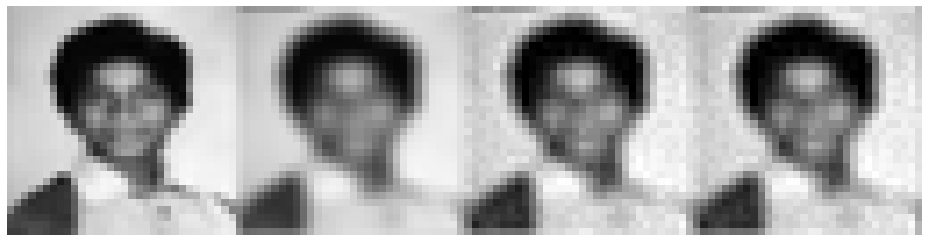

In [30]:
imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (32, 32)),
        Yprime[k].unflatten(-1, (32, 32)),
        (X0[k]).unflatten(-1, (32, 32)),
        (X1[k]).unflatten(-1, (32, 32)),
    ], dim=1).clip(0,1),
    #filename='example_i_deconv_ols'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(X0[k], Xprime[k]).item(),
        utils.metrics.psnr(X1[k], Xprime[k]).item(),
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            Xprime[k].unflatten(-1, (1, 1, 32, 32)), 
            X0[k].unflatten(-1, (1, 1, 32, 32))
        ).item(),
        utils.metrics.ssim(
            Xprime[k].unflatten(-1, (1, 1, 32, 32)), 
            X1[k].unflatten(-1, (1, 1, 32, 32))
        ).item(),
    )
)

PSNR:  8.12092E+01  8.12092E+01
SSIM:  1.00000E+00  1.00000E+00


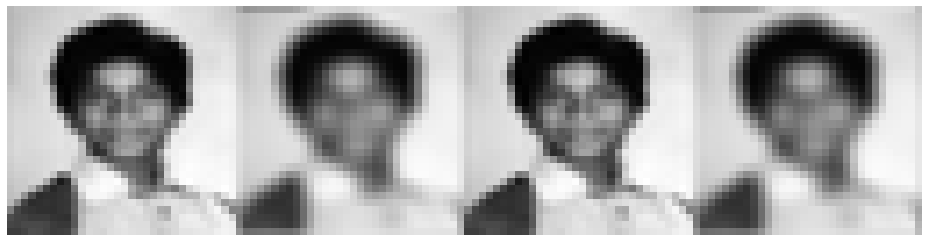

In [31]:
imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (32, 32)),
        Yprime[k].unflatten(-1, (32, 32)),
        (img_clear_res := (Yprime[k] + Wres @ Xprime[k]).unflatten(-1, (32, 32))),
        (img_blur_res := (Xprime[k] - Wres @ Xprime[k]).unflatten(-1, (32, 32))),
    ], dim=1).clip(0,1),
    #filename='example_i_deconv_ols'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_clear_res.flatten(-2, -1), Xprime[k]).item(),
        utils.metrics.psnr(img_blur_res.flatten(-2, -1), Yprime[k]).item(),
    )
)
print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            Xprime[k].unflatten(-1, (1, 1, 32, 32)), 
            img_clear_res[None, None, ...]
        ).item(),
        utils.metrics.ssim(
            Yprime[k].unflatten(-1, (1, 1, 32, 32)), 
            img_blur_res[None, None, ...]
        ).item(),
    )
)

In [32]:
raise NotImplementedError('Stop here!')

NotImplementedError: Stop here!

In [ ]:
class AdjointBilinearOperatorModel(nn.Module):
    
    def __init__(self, device=None):
        super().__init__()
        self.A = nn.Parameter(torch.zeros(32, 32, device=device))
        self.B = nn.Parameter(torch.zeros(32, 32, device=device))
        
        nn.init.kaiming_uniform_(self.A, a=5**.5)
        nn.init.kaiming_uniform_(self.B, a=5**.5)

    def forward(self, x):
        return self.A @ x @ self.B.T
    
    def T(self, y):
        return self.A.T @ y @ self.B

In [ ]:
nets = {
    'BiLinear': AdjointBilinearOperatorModel(device=device)
}
loss_trace = {
    'BiLinear': {}
}
opts = {
    'BiLinear': torch.optim.Adam(nets['BiLinear'].parameters() , lr=nu)
}

In [ ]:
# Define objective function

def objective_function(x=None, xh=None, y=None, yh=None, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    if x is not None:
        losses['lx'] = F.mse_loss(xh, x, reduction=reduction)
    if y is not None:
        losses['ly'] = F.mse_loss(yh, y, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [ ]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x.to(device)
        y = blur_gpu(x)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            xh = nets[cur].T(y)
            #yh = nets[cur](x)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yth = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = F.mse_loss(xth, xt, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                opts[cur].zero_grad()
                with torch.no_grad():
                    xhs[cur] = nets[cur].T(ys)
                    xhs[cur] = xhs[cur].to('cpu').clip(0,1).permute(0, -2, -1, -3)
                    xhs[f'Original'] = xs.to('cpu').clip(0,1).permute(0, -2, -1, -3)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')
            
        i += 1

In [ ]:
imshow(
    torch.cat([
        torch.cat(
            [img for img in (ys).permute(0,-2,-1,-3).detach().cpu().clip(0,1)],
            dim=1
        ),
        torch.cat(
            [img for img in (ys + noise).permute(0,-2,-1,-3).detach().cpu().clip(0,1)],
            dim=1
        ),        
    ])
)


In [ ]:
imshow(
    torch.cat([
        torch.cat(
            [img for img in (nets['BiLinear'].T(ys)).permute(0,-2,-1,-3).detach().cpu().clip(0,1)],
            dim=1
        ),
        torch.cat(
            [img for img in nets['BiLinear'].T(ys + noise).permute(0,-2,-1,-3).detach().cpu().clip(0,1)],
            dim=1
        ),        
    ])
)
